# Comparison to Kruck (2017)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
gal_angle_df = pd.read_csv('lib/gal-metadata.csv', index_col=0)

In [3]:
best_models = pd.read_pickle('lib/best_individual.pickle')
models = pd.read_pickle('lib/models.pickle')

In [4]:
sd = pd.read_csv('../source_files/Kruk2018_Table2_Table3.csv')
sd_coords = SkyCoord(ra=sd['ra']*u.degree, dec=sd['dec']*u.degree)

In [5]:
matches = pd.DataFrame([], columns=sd.columns)
for subject_id in gal_angle_df.index.values:
  gal = gal_angle_df.loc[subject_id]
  sep = sd_coords.separation(
    SkyCoord(ra=gal['RA']*u.degree, dec=gal['DEC']*u.degree)
  )
  idxmin_sep = np.argmin(sep)
  if sep[idxmin_sep] < 1 * u.arcsec:
    matches.loc[subject_id] = sd.iloc[idxmin_sep]

In [6]:
def get_fit_component_string(model):
  ks = ('disk', 'bar', 'bulge')
  return '+'.join(
    k for k in ks
    if model[k] is not None
  ).replace('disk', 'disc')

In [7]:
bi_models_string = models['tuned_best_individual']\
    .apply(get_fit_component_string)
agg_models_string = fitted_models['tuned_aggregate']\
    .apply(get_fit_component_string)

In [8]:
same_comp_info = {
  'gzb': (bi_models_string == agg_models_string),
  'bi': (
    matches['Fit_components']
    == bi_models_string.reindex(matches.index)
  ),
  'agg': (
    matches['Fit_components']
    == agg_models_string.reindex(matches.index)
  )
}

In [9]:
print('\n'.join('{}: {:.4f}'.format(k, v.sum() / v.count()) for k, v in same_comp_info.items()))

gzb: 0.6351
bi: 0.2857
agg: 0.3333


In [10]:
def get_val(comp, param):
  return lambda m: m[comp][param] if m[comp] is not None else np.nan

# models are in units of sloan pixels, 1 arcsecond is 0.386 pixels
# Add the galaxy builder correction due to non-conventionally defined model (1/3)
re_conversion = 1 / 0.386

k = 'tuned_aggregate'
disk_ba = models[k].apply(get_val('disk', 'axRatio'))
bulge_ba = models[k].apply(get_val('bulge', 'axRatio'))
bar_ba = models[k].apply(get_val('bar', 'axRatio'))
disk_re = models[k].apply(get_val('disk', 'rEff')) * re_conversion
bulge_re = models[k].apply(get_val('bulge', 'rEff')) * re_conversion
bar_re = models[k].apply(get_val('bar', 'rEff')) * re_conversion

In [11]:
re_pairs = [
    (
        matches['re_{}'.format(k)].replace(0, np.nan),
        df.reindex(matches.index),
    )
    for k, df in zip(
        ('disc', 'bulge', 'bar'),
        (disk_re, bulge_re, bar_re)
    )
]
ba_pairs = [
    (
        matches['ba_{}'.format(k)].replace(0, np.nan),
        df.reindex(matches.index),
    )
    for k, df in zip(
        ('disc', 'bulge', 'bar'),
        (disk_ba, bulge_ba, bar_ba)
    )
]

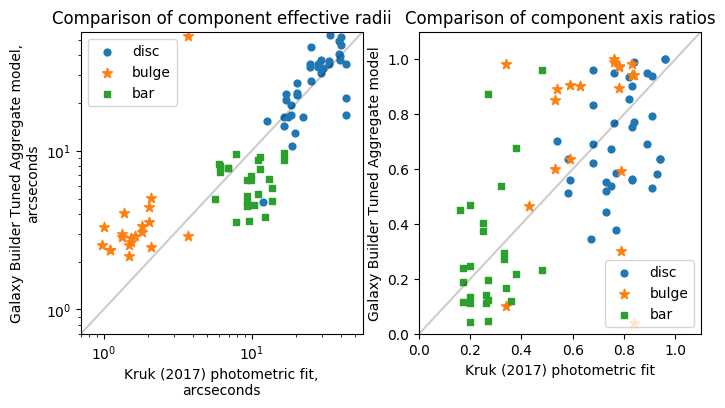

In [12]:
f, axs = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
markers = ('o', '*', 's')
sizes = np.array((6, 14, 6)) * 4
ax = axs[0]
ax.scatter(
    matches['re_disc'].replace(0, np.nan),
    disk_re.reindex(matches.index),
    marker=markers[0], s=sizes[0],
    label='disc',
)
ax.scatter(
    matches['re_bulge'].replace(0, np.nan),
    bulge_re.reindex(matches.index),
    marker=markers[1], s=sizes[1],
    label='bulge',
)
ax.scatter(
    matches['re_bar'].replace(0, np.nan),
    bar_re.reindex(matches.index),
    marker=markers[2], s=sizes[2],
    label='bar',
)
l = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.add_line(plt.Line2D((0.01, 1E4), (0.01, 1E4), c='k', alpha=0.2))
ax.set_title('Comparison of component effective radii')
ax.set_xlabel('Kruk (2017) photometric fit,\narcseconds')
ax.set_ylabel('Galaxy Builder Tuned Aggregate model,\narcseconds')
plt.sca(ax)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.7, l)
plt.ylim(0.7, l)
plt.legend()

ax = axs[1]
ax.scatter(
    matches['ba_disc'].replace(0, np.nan),
    disk_ba.reindex(matches.index),
    marker=markers[0], s=sizes[0],
    label='disc',
)
ax.scatter(
    matches['ba_bulge'].replace(0, np.nan),
    bulge_ba.reindex(matches.index),
    marker=markers[1], s=sizes[1],
    label='bulge',
)
ax.scatter(
    matches['ba_bar'].replace(0, np.nan),
    bar_ba.reindex(matches.index),
    marker=markers[2], s=sizes[2],
    label='bar',
)
ax.add_line(plt.Line2D((0, 2), (0, 2), c='k', alpha=0.2))
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.set_title('Comparison of component axis ratios')
ax.set_xlabel('Kruk (2017) photometric fit')
ax.set_ylabel('Galaxy Builder Tuned Aggregate model')
plt.sca(ax)
plt.legend()
plt.savefig(
    'method-paper-plots/sd_comp_comparison.pdf',
    bbox_inches='tight'
);

What was the sample standard deviation on $\mathrm{Sandor} - \mathrm{Galaxy\ Builder}$?

In [13]:
print('Disc:  {:.4f} arcseconds'.format((
    matches['re_disc'].replace(0, np.nan)
    - disk_re.reindex(matches.index)
).dropna().std()))
print('Bulge: {:.4f} arcseconds'.format((
    matches['re_bulge'].replace(0, np.nan)
    - bulge_re.reindex(matches.index)
).dropna().std()))
print('Bar:   {:.4f} arcseconds'.format((
    matches['re_bar'].replace(0, np.nan)
    - bar_re.reindex(matches.index)
).dropna().std()))

Disc:  9.1368 arcseconds
Bulge: 10.6785 arcseconds
Bar:   3.4204 arcseconds


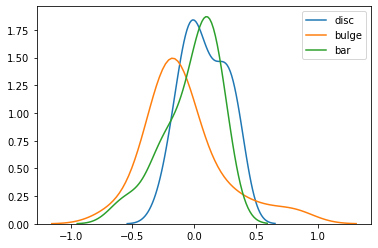

In [14]:
sns.kdeplot((
    matches['ba_disc'].replace(0, np.nan)
    - disk_ba.reindex(matches.index)
).dropna(), label='disc')
sns.kdeplot((
    matches['ba_bulge'].replace(0, np.nan)
    - bulge_ba.reindex(matches.index)
).dropna(), label='bulge')
sns.kdeplot((
    matches['ba_bar'].replace(0, np.nan)
    - bar_ba.reindex(matches.index)
).dropna(), label='bar')

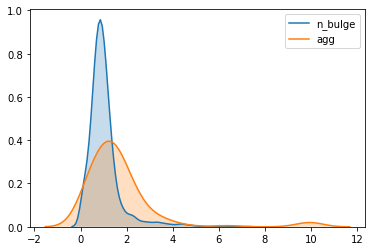

In [15]:
sns.kdeplot(sd['n_bulge'][sd['n_bulge'] > 0], shade=True)
sns.kdeplot(fitted_models[k].apply(get_val('bulge', 'n')).dropna(), shade=True)